# s1 backscatter for lake ice cover

In [1]:
# use `pro` env
from dask.distributed import LocalCluster, Client
import dask
import dask.dataframe as dd
import geopandas as gpd
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
import seaborn as sns
from shapely.geometry import LineString, Point, box, Polygon
import stackstac
import xarray as xr
import lakeIce_utils as liU
from tqdm import tqdm

import importlib
importlib.reload(liU)

<module 'lakeIce_utils' from '/scratch/s1759665/paper2/src/lakeIce_utils.py'>

In [ ]:
# test data
data = np.random.random(size=[50,50,10,2])
xy = np.arange(0, 50)
t = li.dB.time.values[0:10]
b = ['hh', 'hv']
relorb = np.random.choice([51,43,78], 10)

dB = xr.DataArray(
    data,
    coords={'y': xy,
            'x': xy,
            'time': t,
            'band': b,
            'sat:relative_orbit': ('time', relorb)},
    dims=['y', 'x', 'time', 'band'],
    name='dB'
)

angles = np.ones((50,50,3))
angles *= [51,43,78]
angles += np.random.random((50,50,3))

angle = xr.DataArray(
    angles,
    coords = {'y': xy,
              'x': xy,
              'sat:relative_orbit': [51,43,78]},
    name='incident_angle'
)

class test():
    pass

t = test()

t.dB = dB
t.angle_ds = angle
t.id = 7
t.region = 'where'

In [2]:
centrelines = gpd.read_file('../data/streams_v3.geojson')

basins = (gpd.read_file('../data/basins/Greenland_Basins_PS_v1.4.2.shp')
          .dissolve('SUBREGION1'))
centrelines = centrelines.sjoin(basins.drop(columns=['NAME', 'GL_TYPE']),
                                how='left'
                                ).rename(columns={'index_right': 'region'})

lakes = gpd.read_file('../data/lake_areas.geojson')

lakes = lakes.sjoin_nearest(centrelines)
lakes = lakes.sort_values(by='id').drop(columns=['index_right', 'name', 'lake_land'])

In [3]:
@dask.delayed
def lazy_li(row):
    li = liU.Sentinel1(row)

In [6]:
with LocalCluster() as cluster:
    client = cluster.get_client()
    print(client.dashboard_link)    
    
    
    samples = []
    medians = []
    ids = []
    lis = []
    
    for row in tqdm(lakes.to_crs(4326).sample(2).itertuples()):  # add back in tqdm if needed
        
        li = liU.Sentinel1(row)
        lis.append(li)
        
    samples = [li.sampled for li in lis]


http://127.0.0.1:8787/status


0it [00:00, ?it/s]/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/sarsen/sentinel1.py:34: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.open_dataset(product_urlpath, group=group, chunks=chunks, **kwargs)
/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/sarsen/sentinel1.py:34: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing

In [23]:
S = pd.concat(samples).reset_index(drop=True)
S = (S
     .melt(
         ['xy', 'time', 'sat:relative_orbit', 'angle', 'month', 'id', 'region']
         )
     .rename(columns={
         'variable': 'band',
         'value': 'dB'
         }
             )
)
S['angle'] = np.degrees(S['angle'])

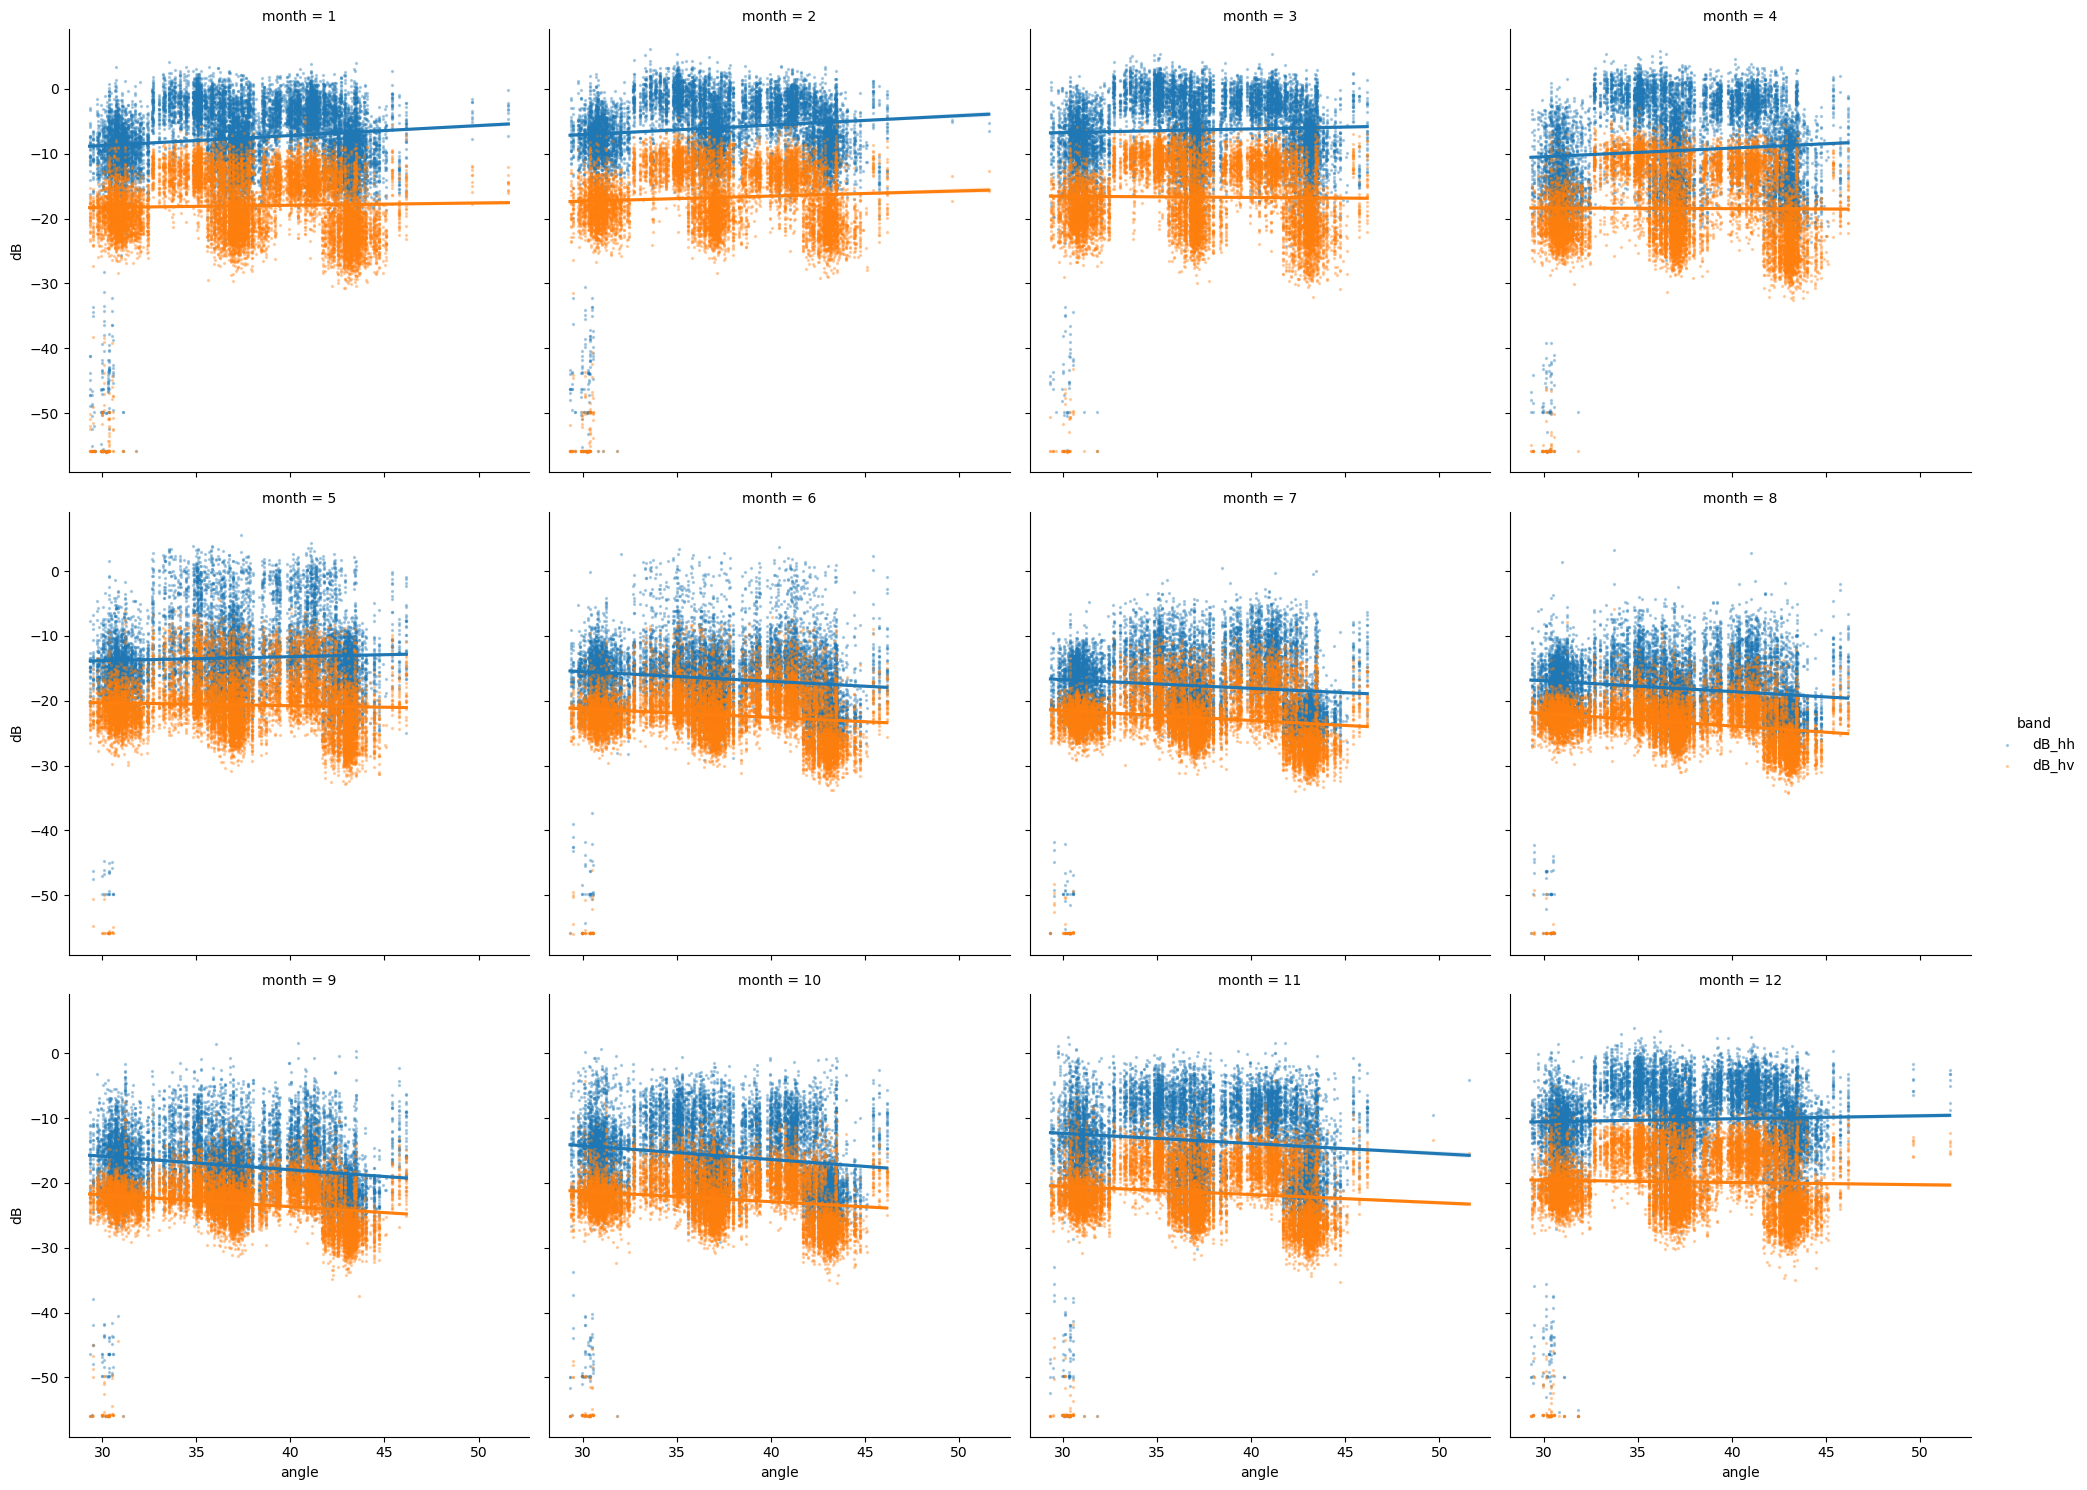

In [26]:
sns.lmplot(data=S,
            x='angle', y='dB',
            col='month',
            col_wrap=4,
            # style='sat:relative_orbit',
            hue='band',
            scatter_kws={'marker':'.', 'alpha':0.3, 's':2})

# fold

In [ ]:
# doesn't need running again because saved output to: '../results/s1_lake_backscatter.parquet'
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
medians = []
ids = []
for row in tqdm(lakes.to_crs(4326).sample(1).itertuples()):
    
    search = catalog.search(collections=['sentinel-1-rtc'],
                            intersects=row.geometry)
    
    s1items = search.item_collection()
    
    # get most common projection
    vals, cnts = np.unique([item.properties['proj:epsg'] for item in s1items] ,return_counts=True)
    epsg = int(vals[np.argmax(cnts)])
    
    # stack & clip
    ds = stackstac.stack(planetary_computer.sign(s1items),
                        epsg=epsg,
                        bounds_latlon=row.geometry.bounds)
    
    mask = (make_geocube(lakes.to_crs(4326).loc[lakes['id']==row.id],
                          fill=np.nan,
                          like=ds)['id']
             .rename('mask'))
    
    # apply mask and convert to dB
    ds_db = xr.where(mask==row.id,
                     10 * np.log10(ds),
                     np.nan)

    median = (ds_db
              .median(dim=['y','x'], skipna=True)
              .rename('dB'))
    
    medians.append(median) # consider making this a future
    ids.append(row.id)
    
with LocalCluster() as cluster:
    client = cluster.get_client()
    print(client.dashboard_link)    
    computed_medians = dask.compute(*medians)
    dfs = []
    for m_ds, id in zip(computed_medians, ids):
        _df = m_ds.to_dataframe()
        _df['myid'] = id
        dfs.append(_df)
    
    df = pd.concat(dfs).reset_index().set_index('time')
    
df.to_parquet('../results/s1_lake_backscatter.parquet')

## wip: getting local incidence angle across sar image

using: 
- https://github.com/egagli/generate_sentinel1_local_incidence_angle_maps/blob/882b9940a843c6dc3040f992ad6bed14201a2f5c/generate_lia.py#L61
- https://github.com/microsoft/PlanetaryComputerExamples/blob/main/tutorials/rtc-qualitative-assessment.ipynb
- and sarsen

In [ ]:
# get a dem
def get_copernicus_dem(geom: Polygon,
                        res: int = 30,
                        ):
    '''
    get Copernicus Global DEM from planetary computer stac catalog
    inputs:
        geom - shapely geometry (polygon / box)
        res - int: resolution of DEM (either 30, or 90, default 30)
        rprj - bool: whether or not to reprojct the dem
        prj - projection to reprject to
        interp - whether or not to interpolate nans
    returns: xarray instance of DEM
    clipped to envelope of `geom`
    if reprojected then not only clipped but also aligned
    with nan's interpolated
    '''

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    search = catalog.search(collections=[f'cop-dem-glo-{res}'],
                            intersects=geom.envelope)

    items = search.item_collection()
    if len(items) > 0:
        dem = (stackstac.stack(
            planetary_computer.sign(items))
            .mean(dim='time', skipna=True)
            .squeeze()
            .rio.write_crs(4326)
            .rio.clip_box(*geom.bounds)
            )
        
    return dem

dem = get_copernicus_dem(row.geometry)
demprj = dem.rio.reproject_match(ds, nodata=np.nan)
dem_prj = demprj.drop_vars(['epsg',
                            'proj:transform',
                            'proj:epsg',
                            'proj:shape']).rio.write_crs(demprj.rio.crs)
if dem_prj.y.diff('y').values[0] < 0:
    dem_prj = dem_prj.isel(y=slice(None, None, -1))
dem_prj.attrs['long_name'] = 'elevation'
dem_prj.attrs['units'] = 'm'
dem_prj = dem_prj.rename('dem').squeeze(drop=True)

dem_ecef = sarsen.scene.convert_to_dem_ecef(dem_prj,
                                            source_crs=demprj.rio.crs)

In [ ]:
# unique relative orbits
unique_relative_orbits = np.unique(ds['sat:relative_orbit'])
folders = []
idx = 0
for orb in unique_relative_orbits:
    
    ids = ds[ds['sat:relative_orbit']==orb].id.values
    
    for id in ids:
        
        try:
            rtc_item = catalog.get_collection('sentinel-1-rtc').get_item(id)
            grd_item = pystac.read_file(rtc_item.get_single_link("derived_from").target)
            
        except Exception as e:
            print(f'an error of type {type(e)}: {e}')
            
        else:
            grd_band = [grd_item.assets.get(band, None)
                        for band in ['hh', 'hv', 'vh', 'vv']
                        if band in grd_item.assets.keys()][0]
            
            folders.append(grd_band.href[53:-23])
            break
orb_dir = dict(zip(unique_relative_orbits, folders))

In [ ]:
def mirror_folder(fs, bucket, folder):
    # from https://github.com/bopen/sarsen/blob/main/notebooks/gamma_wrt_incidence_angle-S1-GRD-IW-RTC-South-of-Redmond.ipynb
    for path, folders, files in fs.walk(f"{bucket}/{folder}"):
        os.makedirs(path[len(bucket) + 1 :], exist_ok=True)
        for f in files:
            file_path = os.path.join(path, f)
            lfile_path = file_path[len(bucket) + 1 :]
            if not os.path.isfile(lfile_path):
                fs.download(file_path, lfile_path + "~")
                os.rename(lfile_path + "~", lfile_path)
                
def slant_to_ground(a, b):
    xrs.slant_range_time_to_ground_range(a, b, coordinate_conversion=coord_conversion)

In [ ]:
bucket = "s1-grd"
# token = planetary_computer.sas.get_token('sentinel1euwest', 's1-grd').token
grd_fs = planetary_computer.get_adlfs_filesystem(account_name='sentinel1euwest',
                                                 container_name='s1-grd')

con_cli = planetary_computer.get_container_client(account_name='sentinel1euwest',
                                                  container_name='s1-grd')
angles = []
for orb, folder in orb_dir.items():
    mirror_folder(grd_fs, bucket, folder)
    orbit_ecef, _ = sarsen.sentinel1.open_dataset_autodetect(folder, group='IW/HH/orbit')
    coord_conv = [grp for grp in sarsen.sentinel1.open_dataset_autodetect(folder)[0].attrs['subgroups'] if 'coordinate_conversion' in grp][0]
    coord_conversion, _ = sarsen.sentinel1.open_dataset_autodetect(folder, group=coord_conv)
    acquisition = sarsen.apps.simulate_acquisition(dem_ecef,
                                                orbit_ecef.position,
                                                slant_range_time_to_ground_range=slant_to_ground,
                                                correct_radiometry=True)
    oriented_area = sarsen.scene.compute_dem_oriented_area(dem_ecef)
    dem_normal = -oriented_area / np.sqrt(xr.dot(oriented_area, oriented_area, dims="axis"))
    orbit_interpolator = sarsen.orbit.OrbitPolyfitIterpolator.from_position(orbit_ecef.position)
    position_ecef = orbit_interpolator.position()
    velocity_ecef = orbit_interpolator.velocity()
    acquisition = sarsen.geocoding.backward_geocode(dem_ecef, orbit_ecef.position, velocity_ecef)
    slant_range = np.sqrt((acquisition.dem_distance**2).sum(dim="axis"))
    dem_direction = acquisition.dem_distance / slant_range
    angle = np.arccos(xr.dot(dem_normal, dem_direction, dims="axis"))
    angles.append(angle)
    

In [ ]:
angle_ds = xr.concat(angles, dim='orbit')
angle_ds['orbit'] = list(orb_dir.keys())

In [ ]:
angle_ds.plot(col='orbit', col_wrap=3)

## get s1 data

In [ ]:
with LocalCluster() as cluster:
    client = cluster.get_client()
    print(client.dashboard_link)    
    computed_medians = dask.compute(*medians)
    dfs = []
    for m_ds, id in zip(computed_medians, ids):
        _df = m_ds.to_dataframe()
        _df['myid'] = id
        dfs.append(_df)
    
    df = pd.concat(dfs).reset_index().set_index('time')
    
df.to_parquet('../results/s1_lake_backscatter.parquet')

In [ ]:
df = pd.read_parquet('../results/s1_lake_backscatter.parquet')
df = df.merge(centrelines['SUBREGION1'], left_on='myid', right_index=True)

In [ ]:
df

In [ ]:
df['sat:relative_orbit'].value_counts()

In [ ]:
df.head()

In [ ]:
df

In [ ]:
site = 1
pol = 'hh'

fig, ax = plt.subplots(figsize=[15,8])
df.loc[(df['myid']==site) & (df['band']==pol)]['dB'].rolling('30d', center=True).median().plot(ax=ax)

In [ ]:
fg = sns.relplot(data=df.groupby(['myid', 'band', 'SUBREGION1'])['dB'].rolling('30d').median().reset_index(),
                 x='time',
                 y='dB',
                 row='SUBREGION1',
                 hue='SUBREGION1',
                 style='myid',
                 palette='tab10',
                 col='band',
                 col_order=['hh'],
                 kind='line',
                 aspect=2,
                #  height=10
                 )

fg.set(ylim=(-22,2))

In [ ]:
df['doy'] = df.index.day_of_year
df['year'] = df.index.year

In [ ]:
smoothed = df.groupby(['myid', 'band', 'SUBREGION1'])['dB'].rolling('30d', min_periods=3, center=True).median().reset_index()
smoothed['doy'] = smoothed['time'].dt.day_of_year
smoothed['year'] = smoothed['time'].dt.year


In [ ]:
sns.relplot(data=smoothed.loc[
    (smoothed['band'].isin(['hh']))
    & (smoothed['year'].isin([2018, 2024]))
    ],
            x='doy',
            y='dB',
            hue='year',
            col='SUBREGION1',
            col_wrap=3,
            # row='SUBREGION1',
            kind='line')